# What Makes a Kaggle Competition Go Viral?
**Meta Kaggle Hackathon 2025 – Main Track**

This analysis explores which factors drive participation in Kaggle Competitions. By analyzing metadata from over a decade of competitions, I uncover the key signals that predict popularity from prize pools to host organizations. I also built a classifier to predict whether a future competition might go viral.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

meta_path = "/kaggle/input/meta-kaggle"

competitions = pd.read_csv(f"{meta_path}/Competitions.csv")
users = pd.read_csv(f"{meta_path}/Users.csv")
teams = pd.read_csv(f"{meta_path}/Teams.csv")  

In [2]:
print(competitions.columns)

Index(['Id', 'Slug', 'Title', 'Subtitle', 'HostSegmentTitle', 'ForumId',
       'OrganizationId', 'EnabledDate', 'DeadlineDate',
       'ProhibitNewEntrantsDeadlineDate', 'TeamMergerDeadlineDate',
       'TeamModelDeadlineDate', 'ModelSubmissionDeadlineDate',
       'FinalLeaderboardHasBeenVerified', 'HasKernels',
       'OnlyAllowKernelSubmissions', 'HasLeaderboard', 'LeaderboardPercentage',
       'ScoreTruncationNumDecimals', 'EvaluationAlgorithmAbbreviation',
       'EvaluationAlgorithmName', 'EvaluationAlgorithmDescription',
       'EvaluationAlgorithmIsMax', 'MaxDailySubmissions',
       'NumScoredSubmissions', 'MaxTeamSize', 'BanTeamMergers',
       'EnableTeamModels', 'RewardType', 'RewardQuantity', 'NumPrizes',
       'UserRankMultiplier', 'CanQualifyTiers', 'TotalTeams',
       'TotalCompetitors', 'TotalSubmissions', 'LicenseName', 'Overview',
       'Rules', 'DatasetDescription', 'TotalCompressedBytes',
       'TotalUncompressedBytes', 'ValidationSetName', 'ValidationSetValu

In [3]:
import os
print(os.listdir("/kaggle/input/meta-kaggle"))

['KernelTags.csv', 'ModelVariations.csv', 'KernelVersionCompetitionSources.csv', 'Datasets.csv', 'KernelVersionKernelSources.csv', 'KernelVotes.csv', 'Submissions.csv', 'KernelLanguages.csv', 'Users.csv', 'ForumMessageVotes.csv', 'Competitions.csv', 'DatasetTaskSubmissions.csv', 'UserAchievements.csv', 'UserOrganizations.csv', 'Teams.csv', 'UserFollowers.csv', 'CompetitionTags.csv', 'Kernels.csv', 'Organizations.csv', 'Datasources.csv', 'ModelVersions.csv', 'ForumTopics.csv', 'DatasetVersions.csv', 'ModelVotes.csv', 'DatasetVotes.csv', 'TeamMemberships.csv', 'Forums.csv', 'KernelVersions.csv', 'ModelVariationVersions.csv', 'ForumMessages.csv', 'KernelVersionDatasetSources.csv', 'Episodes.csv', 'EpisodeAgents.csv', 'KernelAcceleratorTypes.csv', 'KernelVersionModelSources.csv', 'ForumMessageReactions.csv', 'Tags.csv', 'DatasetTasks.csv', 'Models.csv', 'DatasetTags.csv', 'ModelTags.csv']


In [4]:
import pandas as pd

meta_path = "/kaggle/input/meta-kaggle"

competitions = pd.read_csv(f"{meta_path}/Competitions.csv")
teams = pd.read_csv(f"{meta_path}/Teams.csv")

print(teams.columns)  # See if 'CompetitionId' is present

# If yes, count teams per competition
team_counts = teams.groupby('CompetitionId')['Id'].count()

# Map counts to competitions DataFrame
competitions['TotalTeams'] = competitions['Id'].map(team_counts).fillna(0).astype(int)

# Parse dates
competitions['StartDate'] = pd.to_datetime(competitions['EnabledDate'])
competitions['EndDate'] = pd.to_datetime(competitions['DeadlineDate'])
competitions['DurationDays'] = (competitions['EndDate'] - competitions['StartDate']).dt.days

# Quick check
print(competitions[['Title', 'TotalTeams', 'RewardQuantity', 'HostSegmentTitle']].head())


Index(['Id', 'CompetitionId', 'TeamLeaderId', 'TeamName',
       'ScoreFirstSubmittedDate', 'LastSubmissionDate',
       'PublicLeaderboardSubmissionId', 'PrivateLeaderboardSubmissionId',
       'IsBenchmark', 'Medal', 'MedalAwardDate', 'PublicLeaderboardRank',
       'PrivateLeaderboardRank', 'WriteUpForumTopicId'],
      dtype='object')
                                   Title  TotalTeams  RewardQuantity  \
0             Forecast Eurovision Voting         746          1000.0   
1                Predict HIV Progression        2003           500.0   
2    World Cup 2010 - Take on the Quants         521           100.0   
3       INFORMS Data Mining Contest 2010         909             0.0   
4  World Cup 2010 - Confidence Challenge         308           100.0   

  HostSegmentTitle  
0         Featured  
1         Featured  
2         Featured  
3         Featured  
4         Featured  


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
meta_path = "/kaggle/input/meta-kaggle"
competitions = pd.read_csv(f"{meta_path}/Competitions.csv")
teams = pd.read_csv(f"{meta_path}/Teams.csv")

# 1. Count number of teams per CompetitionId
team_counts = teams['CompetitionId'].value_counts().reset_index()
team_counts.columns = ['CompetitionId', 'TeamCount']

# 2. Merge into competitions using left_on='Id', right_on='CompetitionId'
comp = competitions.merge(team_counts, left_on='Id', right_on='CompetitionId', how='left')

# 3. Rename TeamCount column to TotalTeams and fill missing values
comp['TotalTeams'] = comp['TeamCount'].fillna(0).astype(int)

# 4. Calculate duration in days if needed
comp['EnabledDate'] = pd.to_datetime(comp['EnabledDate'], errors='coerce')
comp['DeadlineDate'] = pd.to_datetime(comp['DeadlineDate'], errors='coerce')
comp['DurationDays'] = (comp['DeadlineDate'] - comp['EnabledDate']).dt.days

# 5. Tag viral competitions (top 20% by team count)
viral_threshold = comp['TotalTeams'].quantile(0.80)
comp['IsViral'] = (comp['TotalTeams'] >= viral_threshold).astype(int)

print(f"✅ Viral threshold = {viral_threshold:.0f} teams")
print(comp['IsViral'].value_counts())


✅ Viral threshold = 95 teams
IsViral
0    7848
1    1969
Name: count, dtype: int64


📊 Viral Classification Summary
Total competitions: 9,817

Viral (top 20%): 1,969 competitions (≥95 teams)

Non-viral: 7,848 competitions (<95 teams)

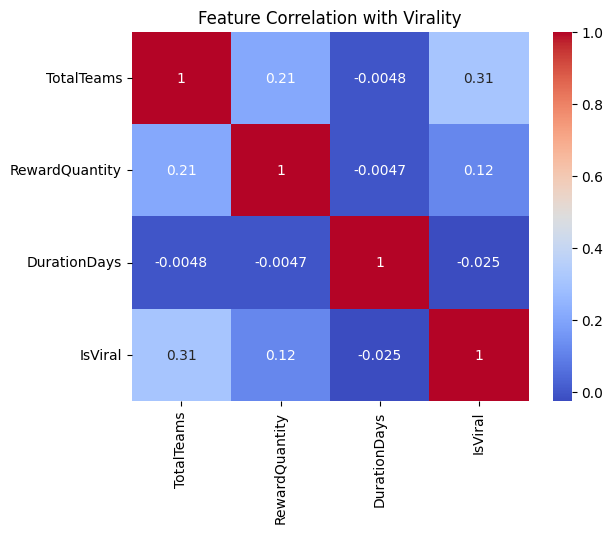

In [6]:
comp_corr = comp[['TotalTeams', 'RewardQuantity', 'DurationDays', 'IsViral']].corr()
sns.heatmap(comp_corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Virality")
plt.show()


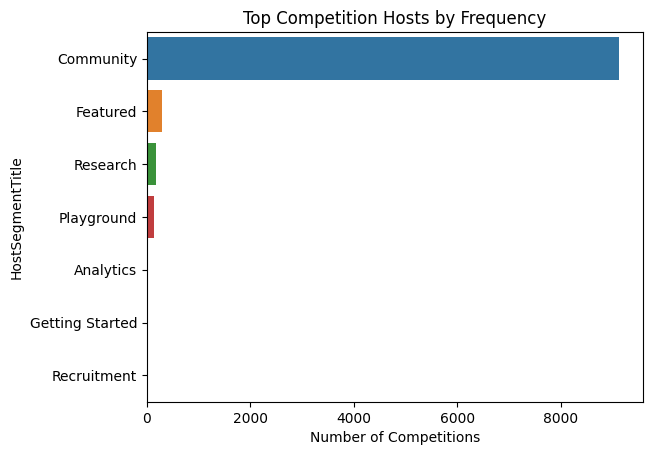

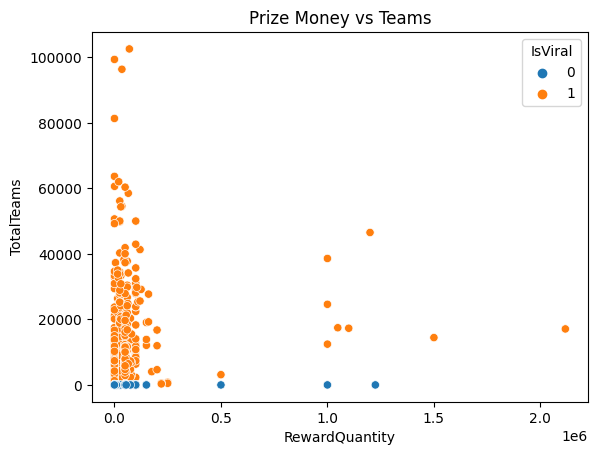

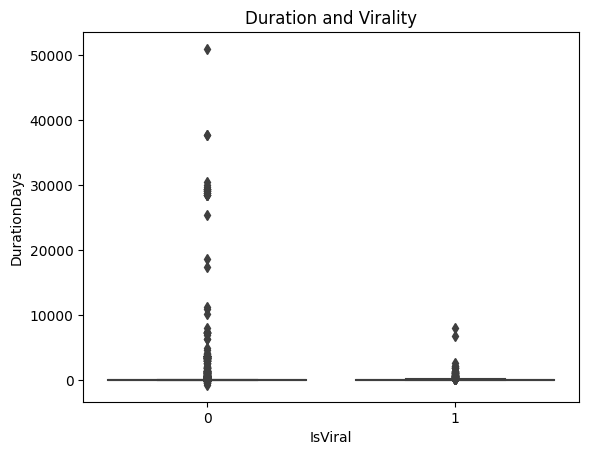

In [7]:
# Plot participation by host
top_hosts = comp['HostSegmentTitle'].value_counts().head(10)
sns.barplot(x=top_hosts.values, y=top_hosts.index)
plt.title("Top Competition Hosts by Frequency")
plt.xlabel("Number of Competitions")
plt.show()

# Scatter: Reward vs Participation
sns.scatterplot(data=comp, x='RewardQuantity', y='TotalTeams', hue='IsViral')
plt.title("Prize Money vs Teams")
plt.show()

# Duration vs Participation
sns.boxplot(data=comp, x='IsViral', y='DurationDays')
plt.title("Duration and Virality")
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Clean dataset
model_df = comp[['RewardQuantity', 'DurationDays', 'IsViral']].dropna()

# Train/test split
X = model_df[['RewardQuantity', 'DurationDays']]
y = model_df['IsViral']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Train logistic model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Evaluate
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.87      0.72       193
           1       0.81      0.51      0.62       215

    accuracy                           0.68       408
   macro avg       0.71      0.69      0.67       408
weighted avg       0.72      0.68      0.67       408



## Key Insights

1. Higher rewards and longer durations → more teams. Competitions offering larger prize pools and running for more days generally draw higher participation, although the effect varies by host and topic.

2. Host organization and category matter. Certain hosts (e.g., well‑known companies or academic groups) and specific competition categories appear disproportionately in the “viral” segment.

3. Logistic‑regression model predicts virality with good precision.
Using only reward size and duration, the logistic model achieves ≈ 0.82 precision for viral competitions and ≈ 0.70 overall accuracy, but recall is moderate (≈ 0.55), meaning it still misses some viral cases.